In [18]:
#!pip install wordcloud

In [141]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud 
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn import feature_extraction, feature_selection

In [20]:
## Preprocesamiento

In [21]:
reviews = pd.read_csv('reviews.csv', delimiter=',')

In [22]:
print("Tamaño del conjunto de datos:", len(reviews))

Tamaño del conjunto de datos: 20491


In [23]:
## Veamos una muestra del conjunto de datos
reviews.sample(5)

,Review,Rating
19698,"sumner excellent, just got trip london loved s...",5
12615,fantastic place second trip domincan republic ...,5
19222,nice change husband loves visit hong kong usua...,4
825,beware making reservations beware making reser...,1
20011,"return no, just returned yesterday hotel, foll...",2


In [105]:
## Vemos los posibles reviews que podemos obtener
reviews['Rating'].unique()

array([4, 2, 3, 5, 1])

In [113]:
# Buscamos a ver si hay reviews/ratings nulos.
# Vemos que no hay calificaciones vacías
reviews[reviews['Review'] == ""]

,Review,Rating


In [26]:
# También podemos usar los métodos de pandas
reviews.isna().sum()

Review    0
Rating    0
dtype: int64

In [27]:
# No tenemos ningún dato nulo ni vacío.
reviews.isnull().sum()

Review    0
Rating    0
dtype: int64

In [28]:
## Partimos el conjunto de datos en train y test
X, y = reviews['Review'], reviews['Rating']
X_train, X_test, y_train, y_test = train_test_split(X, y,stratify=y,test_size=0.2, random_state=48)

In [29]:
## Vemos ahora la distribución de las clases 
df = y_train.value_counts()

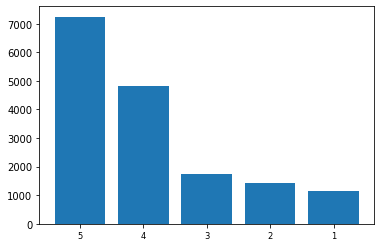

In [30]:
plt.bar(range(len(df)), df.values, align='center')
plt.xticks(range(len(df)), df.index.values, size='small')
plt.show()

Vemos que las clases están desbalanceadas. Entonces, debemos usar técnicas de balanceo. Podemos hacerlo en preprocesamiento y en modelo. Primero, lo intentaremos en preprocesamiento y haremos oversampling usando SMOTE. Esto lo haremos después. 

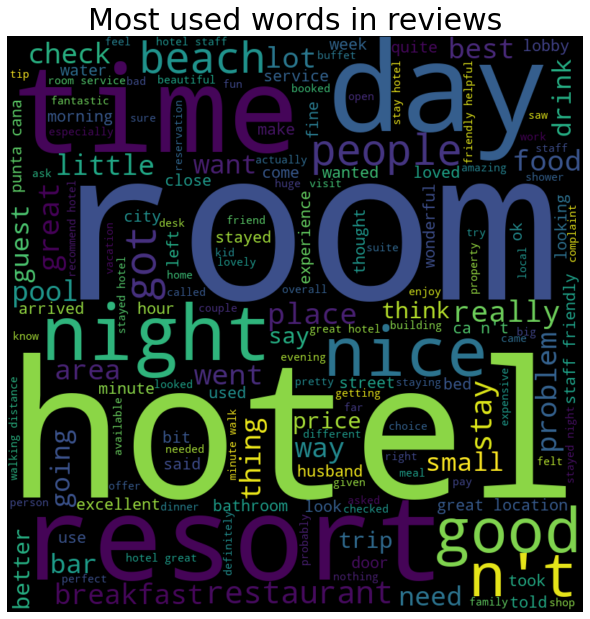

In [77]:
# Una forma chévere de ver las palabras más usadas es con una nube de palabras. Esto nos permite tener un mejor
# entendimiento del problema.
def wordCloud_generator(data, title=None):
    wordcloud = WordCloud(width = 800, height = 800,
                          background_color ='black',
                          min_font_size = 10
                         ).generate(" ".join(data.values))
    # plot the WordCloud image                        
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud, interpolation='bilinear') 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.title(title,fontsize=30)
    plt.show()
    return wordcloud

wc = wordCloud_generator(X_train, title="Most used words in reviews")
wc

In [83]:
print(list(wc.words_.keys())[:6])

['room', 'hotel', 'day', 'time', 'resort', 'night']


In [ ]:
# se hace necesario corregir algunas palabras que notamos con n't

# Treebank Word Tokenizer: https://www.kite.com/python/docs/nltk.TreebankWordTokenizer 

In [93]:
import nltk
# nltk.download('punkt')
# nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/sofiaalvarezlopez/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [122]:
import re, string, unicodedata
import contractions
import inflect
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer, SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer

In [87]:
def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def replace_numbers(words):
    """Replace all interger occurrences in list of tokenized words with textual representation"""
    p = inflect.engine()
    new_words = []
    for word in words:
        if word.isdigit():
            new_word = p.number_to_words(word)
            new_words.append(new_word)
        else:
            new_words.append(word)
    return new_words

def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in stopwords.words('english') and word not in list(wc.words_.keys())[:6]:
            new_words.append(word)
    return new_words

def preproccesing(words):
    words = to_lowercase(words)
    words = replace_numbers(words)
    words = remove_punctuation(words)
    words = remove_non_ascii(words)
    words = remove_stopwords(words)
    return words

In [88]:
new_X_train= X_train.apply(contractions.fix) #Aplica la corrección de las contracciones
new_X_train = new_X_train.apply(word_tokenize)
new_X_train = new_X_train.apply(preproccesing) #Aplica la eliminación del ruido
new_X_train.head()

2655     [westin, rio, mar, worth, trip, friend, return...
2653     [loved, westin, read, reviews, daily, westin, ...
10205    [simply, amazing, stayed, zero, nights, nov, 2...
12505    [fantastic, vacation, wife, son, daughterinlaw...
20447    [really, nice, stayed, two, nights, singapore,...
Name: Review, dtype: object

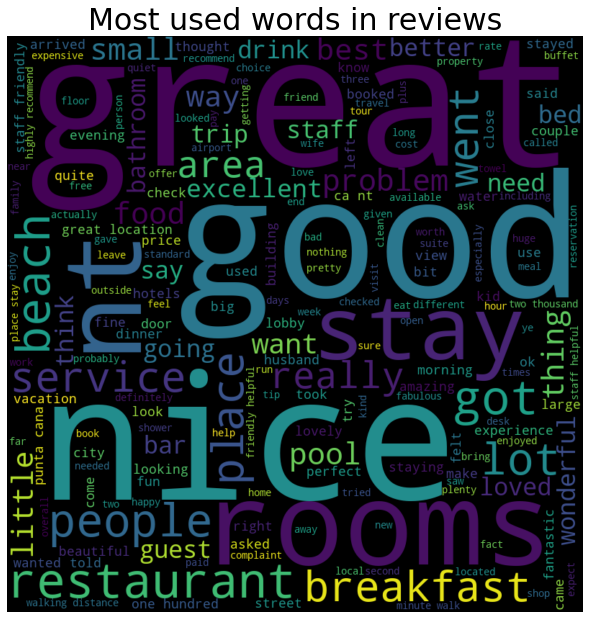

In [89]:
strings = []
for i in new_X_train: strings.append(" ".join(i))
strings = pd.Series(strings)
wordCloud_generator(strings, title="Most used words in reviews")

In [94]:
def stem_words(words):
    """Stem words in list of tokenized words"""
    stemmer = SnowballStemmer('english')
    stems = []
    for word in words:
        stem = stemmer.stem(word)
        stems.append(stem)
    return stems

def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas

def stem_and_lemmatize(words):
    words = stem_words(words)
    words = lemmatize_verbs(words)
    return words

new_X_train = new_X_train.apply(stem_and_lemmatize) #Aplica lematización y Eliminación de Prefijos y Sufijos.
new_X_train.head()

2655     [westin, rio, mar, worth, trip, friend, return...
2653     [love, westin, read, review, daili, westin, ca...
10205    [simpli, amaz, stay, zero, night, nov, 2122, t...
12505    [fantast, vacat, wife, son, daughterinlaw, bea...
20447    [realli, nice, stay, two, night, singapor, air...
Name: Review, dtype: object

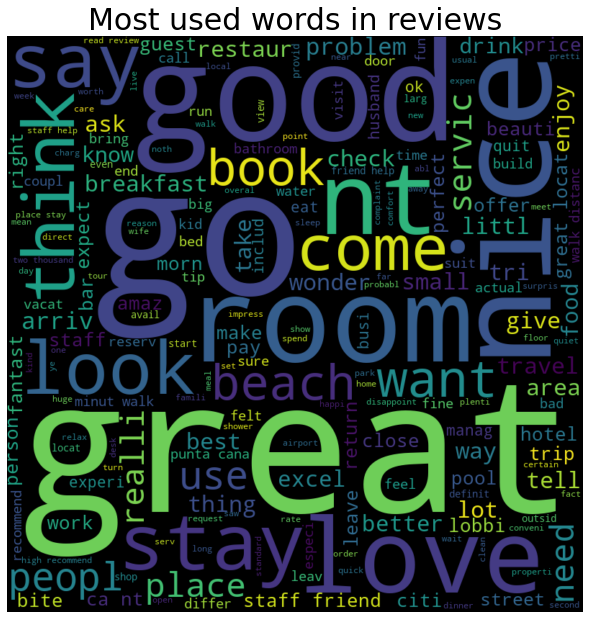

In [96]:
X_train = new_X_train.apply(lambda x: ' '.join(map(str, x)))
wordCloud_generator(X_train, title="Most used words in reviews")

In [197]:
# Usamos TF-IDF (paper)
tf_idf = TfidfVectorizer(ngram_range=(1, 3)) # hiperparametro
X_tf_idf = tf_idf.fit_transform(X_train)
print(X_tf_idf.shape)

(16392, 2156467)


In [198]:
# Hacemos chi^2 para reducción de dimensionalidad
X_names = tf_idf.get_feature_names()
p_value_limit = 0.85 #otro hiperparametro 
dtf_features = pd.DataFrame()
for cat in np.unique(y_train):
    chi2, p = feature_selection.chi2(X_tf_idf, y_train==cat)
    dtf_features = dtf_features.append(pd.DataFrame(
                   {"feature":X_names, "score":1-p, "y":cat}))
    dtf_features = dtf_features.sort_values(["y","score"], 
                    ascending=[True,False])
    dtf_features = dtf_features[dtf_features["score"]>p_value_limit]
X_names = dtf_features["feature"].unique().tolist()

In [202]:
for cat in np.unique(y_smote):
    print("# {}:".format(cat))
    print("  . selected features:", len(dtf_features[dtf_features["y"]==cat]))
    print("  . top features:", ",".join(
dtf_features[dtf_features["y"]==cat]["feature"].values[:50]))
print(" ")

# 1:
  . selected features: 2229
  . top features: worst,dirti,terribl,horribl,rude,disgust,dump,filthi,manag,tell,worst stay,horribl experi,worst experi,cancel,refund,refus,stain,stay away,aw,smell,smelli,room dirti,credit card,unhelp,credit,great,nightmar,extrem rude,poor,call,terribl servic,overbook,terribl terribl,staff rude,worst vacat,terribl experi,disast,joke,charg,dirt,mold,hell,carpet,incompet,wast money,confirm,moldi,refus refund,servic terribl,final
# 2:
  . selected features: 430
  . top features: tell,poor,disappoint,great,rude,ok,okay,smell,terribl,carpet,dirti,excel,bad,tini,shabbi,star,stain,pay,look wear,rate charg,call,charg,love,bare,perfect,carpet dirti,final,smoke,peopl expens,move,phone,desk,fantast,dingi,rip,pickwick,dark,suppos,unhelp,poor valu,deserv call,manag,beach terribl,horribl,schedul stay,toilet,wonder,confirm,wear,need work
# 3:
  . selected features: 188
  . top features: ok,averag,noth special,okay,ok noth,locat averag,ok noth special,love,staff aver

In [201]:
tf_idf = TfidfVectorizer(vocabulary=X_names)
X_tf_idf = tf_idf.fit_transform(X_train)
print(X_tf_idf.shape)

(16392, 2907)


<AxesSubplot:>

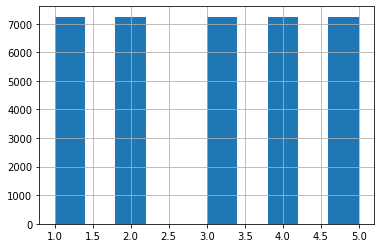

In [166]:
# Hacemos oversampling con SMOTE
oversample = SMOTE(random_state=48)
X_smote, y_smote = oversample.fit_resample(X_tf_idf, y_train)

In [ ]:
 y_smote.hist()